In [1]:
%%capture
!pip install shap numpy pandas matplotlib scikit-learn lightgbm tensorflow torch transformers plotly wordcloud ipywidgets

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud
from ipywidgets import interact
import shap
shap.initjs()  # For better visualizations

# Scikit-learn models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, fetch_california_housing

# TensorFlow/Keras for CNN
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Transformers (BERT)
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch

# **1. Tabular Data Models (Scikit-learn, XGBoost, LightGBM)**

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


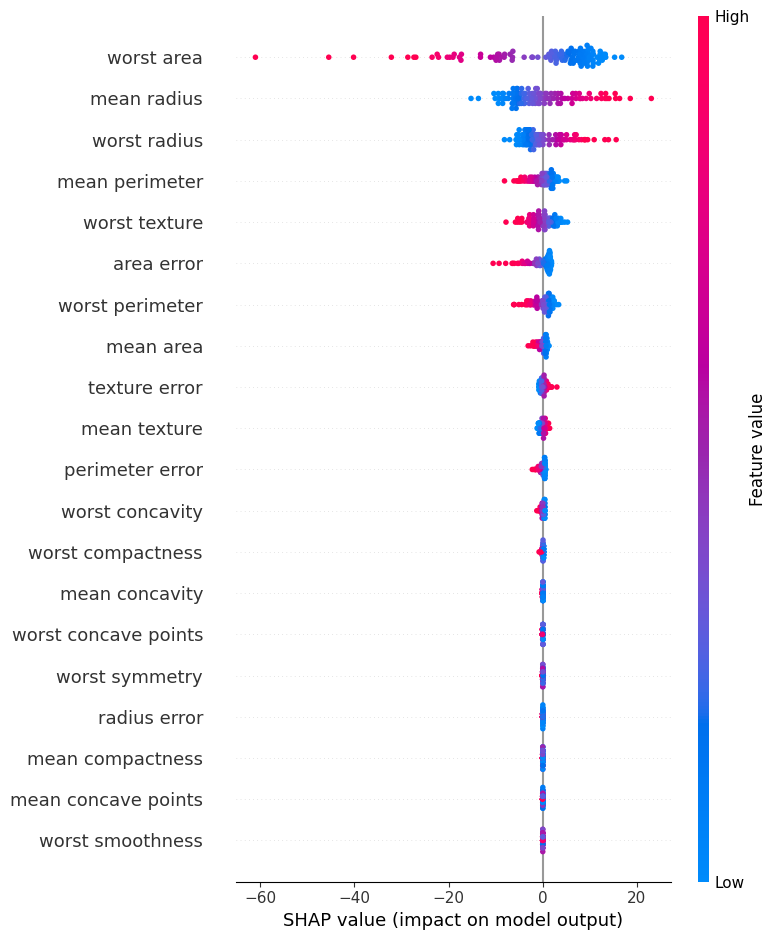

In [3]:
# Load dataset
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# SHAP interpretation
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Interactive summary plot
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)
plt.show()

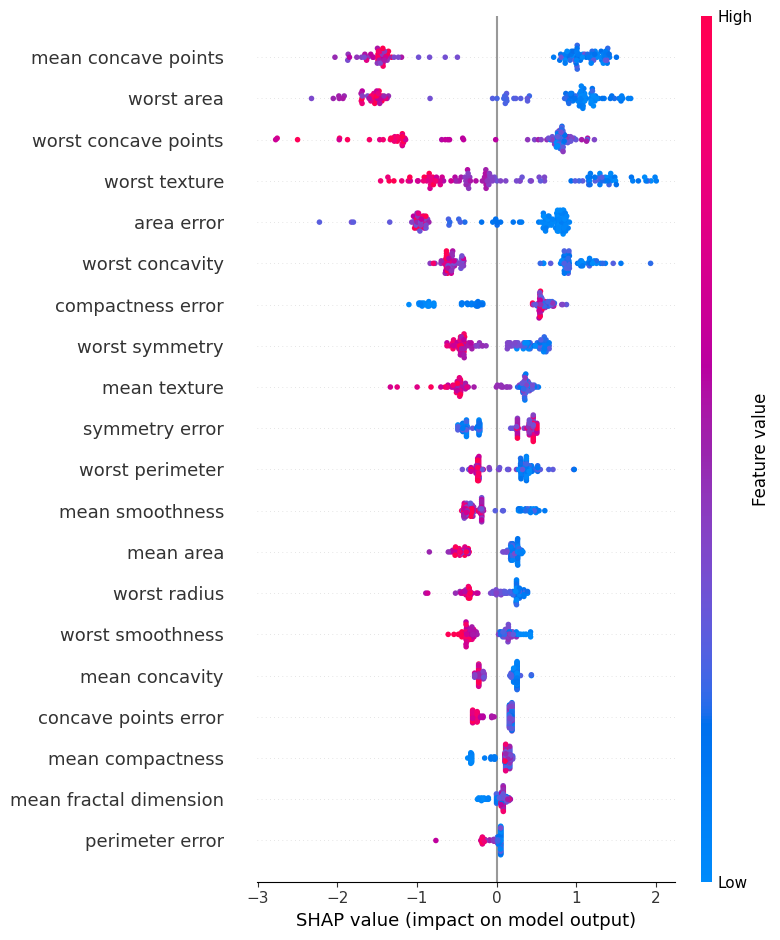

In [4]:
# Train model
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)

# SHAP interpretation
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Interactive summary plot
shap.summary_plot(shap_values, X_test, feature_names=data.feature_names)
plt.show()

# **2. Deep Learning for Images (Keras CNN, MNIST)**

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 38s 40ms/step - accuracy: 0.8697 - loss: 0.5077
Epoch 2/2
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 26ms/step - accuracy: 0.9712 - loss: 0.1026


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(5, 28, 28, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 28, 28, 1))']
  warnings.warn(msg)


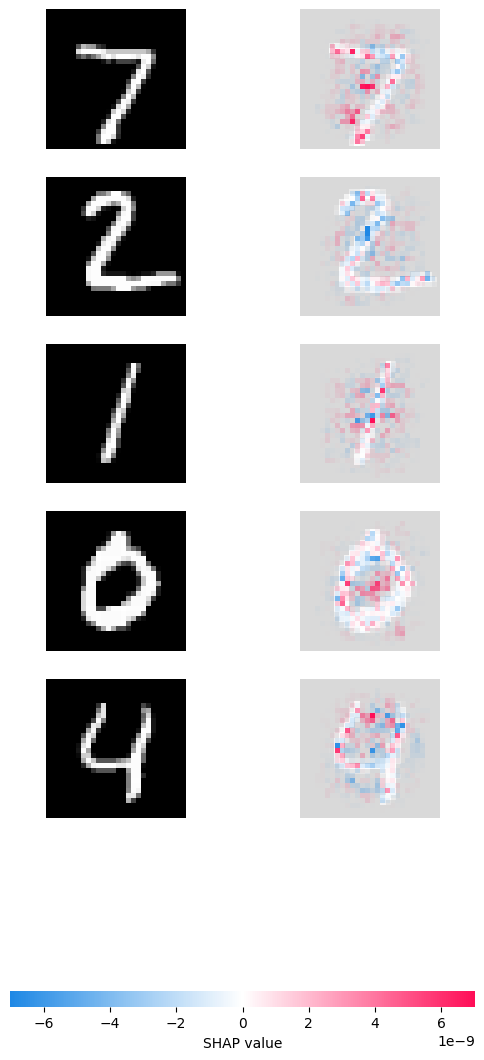

In [5]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# Build a simple CNN
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(10, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=64)

# Select a subset for SHAP (computationally expensive)
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]
test_images = X_test[:5]

# SHAP Explanation
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_images)

# Visualize pixel contributions
shap.image_plot(shap_values, test_images)

# **3. NLP with Transformers (BERT/DistilBERT)**

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

PermutationExplainer explainer: 2it [00:30, 30.85s/it]               


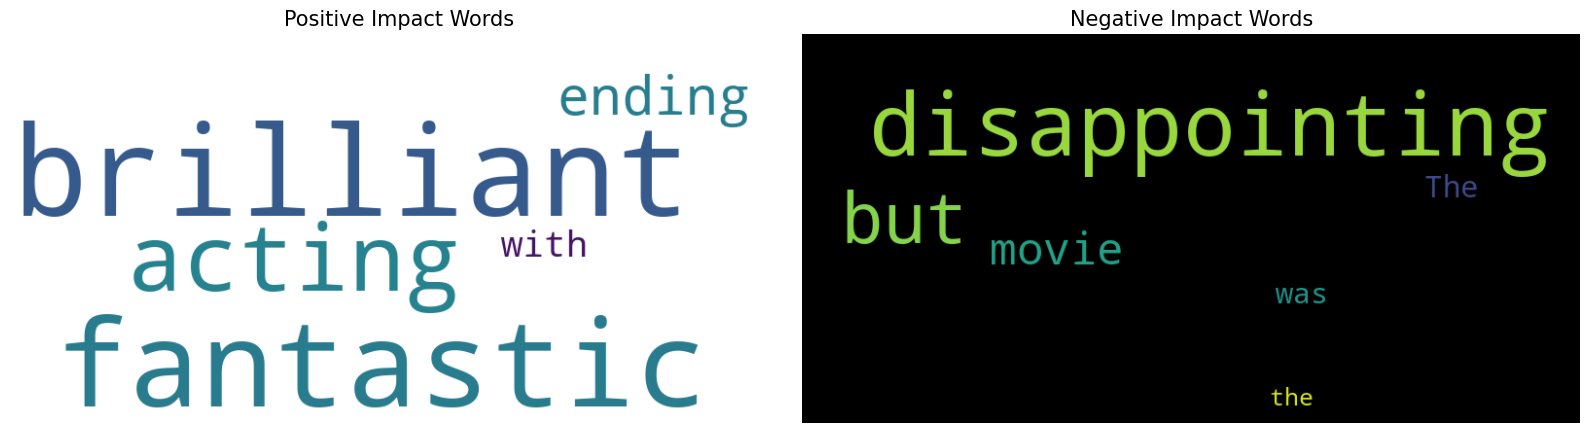

In [6]:
# 1. Load Model and Tokenizer
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# 2. Robust Prediction Function
def predict(texts):
    # Convert all inputs to list format
    if isinstance(texts, str):
        texts = [texts]
    elif isinstance(texts, np.ndarray):
        texts = texts.tolist()

    # Process each text separately
    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)
        probas = torch.softmax(outputs.logits, dim=-1).numpy()
        results.append(probas[0])  # Take only the first result
    return np.array(results)

# 3. Sample Texts for Analysis
texts = [
    "The movie was fantastic with brilliant acting but the ending was disappointing",
    "I've never seen such a terrible performance from the lead actor",
    "The plot was predictable yet somehow still enjoyable"
]

# 4. Create SHAP Explainer with Improved Method
explainer = shap.Explainer(
    model=predict,
    masker=tokenizer,
    output_names=["Negative", "Positive"],
    algorithm="permutation"  # Changed algorithm for better compatibility
)

# Calculate SHAP values (start with just one example)
shap_values = explainer(texts[:1])  # First try with just one text

# --------------------------------------------------
# Advanced Visualization Techniques (after successful SHAP calculation)
# --------------------------------------------------

# 1. Basic Visualization to Start
shap.plots.text(shap_values)

# 2. Word Cloud of Feature Impacts (after successful initial calculation)
def plot_word_cloud(shap_values, class_idx=1):
    pos_words = {}
    neg_words = {}

    for i in range(len(shap_values.values)):
        for j in range(len(shap_values[i].values)):
            word = shap_values[i].data[j]
            val = shap_values[i].values[j][class_idx]

            if val > 0:
                pos_words[word] = abs(val)
            else:
                neg_words[word] = abs(val)

    plt.figure(figsize=(16, 8))

    plt.subplot(1, 2, 1)
    wc = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(pos_words)
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Positive Impact Words", fontsize=15)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    wc = WordCloud(width=800, height=400, background_color='black').generate_from_frequencies(neg_words)
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Negative Impact Words", fontsize=15)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Only execute if SHAP values were calculated successfully
if 'shap_values' in locals():
    try:
        plot_word_cloud(shap_values)
    except Exception as e:
        print(f"Error in word cloud: {e}")